# A simple worked example of Shap

This notebook shows a very simple example of Shap. We examine scores in a pub quiz. Those scores depend on the players present (Tim, Mark, and Carrie). The pub quiz team can have any number and combination of players - including none of the team turning up!

Data has been generated according to a known algorithm:

1) Add 3 marks if Tim is present
2) Add 6 marks if Mark is present
3) Add 9 marks if Carrie is present
4) Add 0-20% (as an integer)

We then fit an XGBoost regressor model (`pip install xgboost` if required) to predict the score given any number and combination of players, and then fit a Shap model (`pip install shap` if required) to explore the XGBoost model.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

## Load data

In [3]:
scores = pd.read_csv('shap_example.csv')

Show first eight scores (a single set of all combinations).

In [4]:
scores.head(8)

,Tim,Mark,Carrie,Score
0,0,0,0,0
1,1,0,0,4
2,0,1,0,6
3,0,0,1,11
4,1,1,0,11
5,1,0,1,14
6,0,1,1,15
7,1,1,1,19


## Calculate average of all games

Shap values show change from the global average of all scores.

In [5]:
global_average = scores['Score'].mean()
print(f'Global average: {global_average:0.1f}')

Global average: 9.8


## Show averages by whether player is present or not

Show averages by whether player is present or not, and show difference from average score.

In [6]:
players = ['Tim', 'Mark', 'Carrie']
for player in players:
    print(f'Average scores wrt {player}')
    average_scores = scores.groupby(player).mean()['Score']
    print(average_scores.round(1))
    print('\nDifference from average:')
    difference = average_scores - global_average
    print(difference.round(1))
    print('\n')

Average scores wrt Tim
Tim
0     8.1
1    11.6
Name: Score, dtype: float64

Difference from average:
Tim
0   -1.8
1    1.8
Name: Score, dtype: float64


Average scores wrt Mark
Mark
0     6.8
1    12.8
Name: Score, dtype: float64

Difference from average:
Mark
0   -3.0
1    3.0
Name: Score, dtype: float64


Average scores wrt Carrie
Carrie
0     5.2
1    14.4
Name: Score, dtype: float64

Difference from average:
Carrie
0   -4.6
1    4.6
Name: Score, dtype: float64




## Split into X and y and fit XGBoost regressor model

In [7]:
X = scores.drop('Score', axis=1)
y = scores['Score']

In [8]:
# Define model
model = XGBRegressor()

# Fit model
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=36,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Get predictions and plot observed vs. predicted

(Predicted includes a random component to score, so no model can be exact).

In [9]:
y_pred = model.predict(X)

In [10]:
y_array = np.array(y).reshape(-1,1)
y_pred_array = np.array(y_pred).reshape(-1,1)
slr = LinearRegression()
slr.fit(y_array, y_pred_array)
y_pred_best_fit = slr.predict(y_array)
r_square = metrics.r2_score(y_array, y_pred_best_fit)

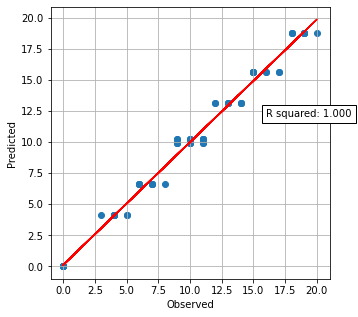

In [11]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot()
ax.scatter(y, y_pred)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

ax.plot (y, slr.predict(y_array), color = 'red')
text = f'R squared: {r_square:.3f}'
ax.text(16, 12, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
ax.grid()
plt.show()

## Train Shap model

In [12]:
# Train explainer on Training set
explainer = shap.TreeExplainer(model, X)

# Get Shapley values along with base and features
shap_values_extended = explainer(X)
shap_values = shap_values_extended.values

## Show beeswarm of Shap

The Beeswarm plot shows the Shap values for each instance predicted. Each player has a Shap value for their presence or absence in a team, which shows the effect of their presence/absence compared with the global average of all scores.

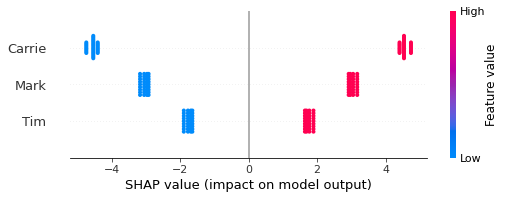

In [13]:
features = list(X)

shap.summary_plot(shap_values=shap_values, 
                  features=X,
                  feature_names=features,
                  show=False)
plt.show()

## Calculate Shap for each player when present or not

Here we calculate the average Shap values for the absence and presence of a player in the team.

In [14]:
shap_summary_by_player = dict()
for player in list(X):
    player_shap_values = shap_values_extended[:, player]
    df = pd.DataFrame()
    df['player_present'] = player_shap_values.data
    df['shap'] = player_shap_values.values
    shap_summary = df.groupby('player_present').mean()
    shap_summary_by_player[player] = shap_summary  

In [15]:
for player in list(X):
    print (f'Shap for {player}:')
    print(shap_summary_by_player[player].round(1))
    print()

Shap for Tim:
                shap
player_present      
0               -1.7
1                1.7

Shap for Mark:
                shap
player_present      
0               -3.0
1                3.0

Shap for Carrie:
                shap
player_present      
0               -4.6
1                4.6



## Show waterfall plots for lowest and highest scores

Waterfall plots show the influence of features on the predicted outcome starting from a baseline model prediction.

Here we show the lowest and highest score.

In [16]:
# Get the location of an example each where probability of giving thrombolysis
# is <0.1 or >0.9

location_low_score = np.where(y_pred == np.min(y_pred))[0][0]
location_high_score = np.where(y_pred == np.max(y_pred))[0][0]

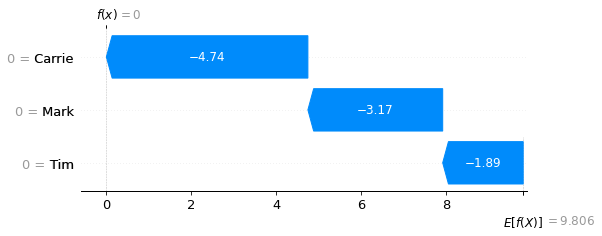

In [17]:
fig = shap.plots.waterfall(shap_values_extended[location_low_score])

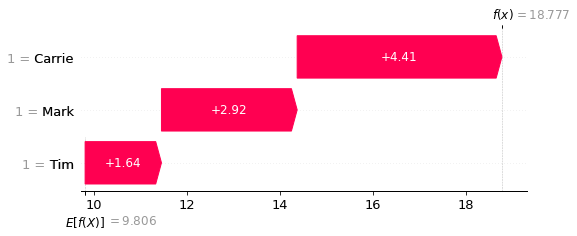

In [18]:
fig = shap.plots.waterfall(shap_values_extended[location_high_score])

Pick a random example.

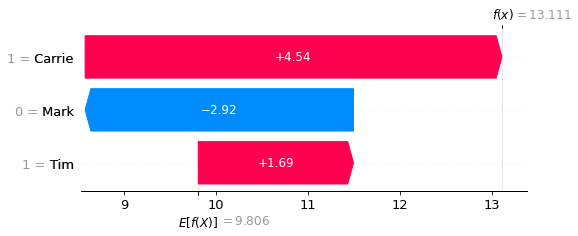

In [19]:
random_location = np.random.randint(0, len(scores))
fig = shap.plots.waterfall(shap_values_extended[random_location])